# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Откройте файл с данными и изучите общую информацию. 

In [19]:
import pandas as pd
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
 
except:
    data = pd.read_csv('\C:\DA\datasets\real_estate_data.csv', sep='\t')

data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


**Построим общую гистограмму для всех числовых столбцов таблицы:**

array([[<Axes: title={'center': 'total_images'}>,
        <Axes: title={'center': 'last_price'}>,
        <Axes: title={'center': 'total_area'}>,
        <Axes: title={'center': 'rooms'}>],
       [<Axes: title={'center': 'ceiling_height'}>,
        <Axes: title={'center': 'floors_total'}>,
        <Axes: title={'center': 'living_area'}>,
        <Axes: title={'center': 'floor'}>],
       [<Axes: title={'center': 'kitchen_area'}>,
        <Axes: title={'center': 'balcony'}>,
        <Axes: title={'center': 'airports_nearest'}>,
        <Axes: title={'center': 'cityCenters_nearest'}>],
       [<Axes: title={'center': 'parks_around3000'}>,
        <Axes: title={'center': 'parks_nearest'}>,
        <Axes: title={'center': 'ponds_around3000'}>,
        <Axes: title={'center': 'ponds_nearest'}>],
       [<Axes: title={'center': 'days_exposition'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

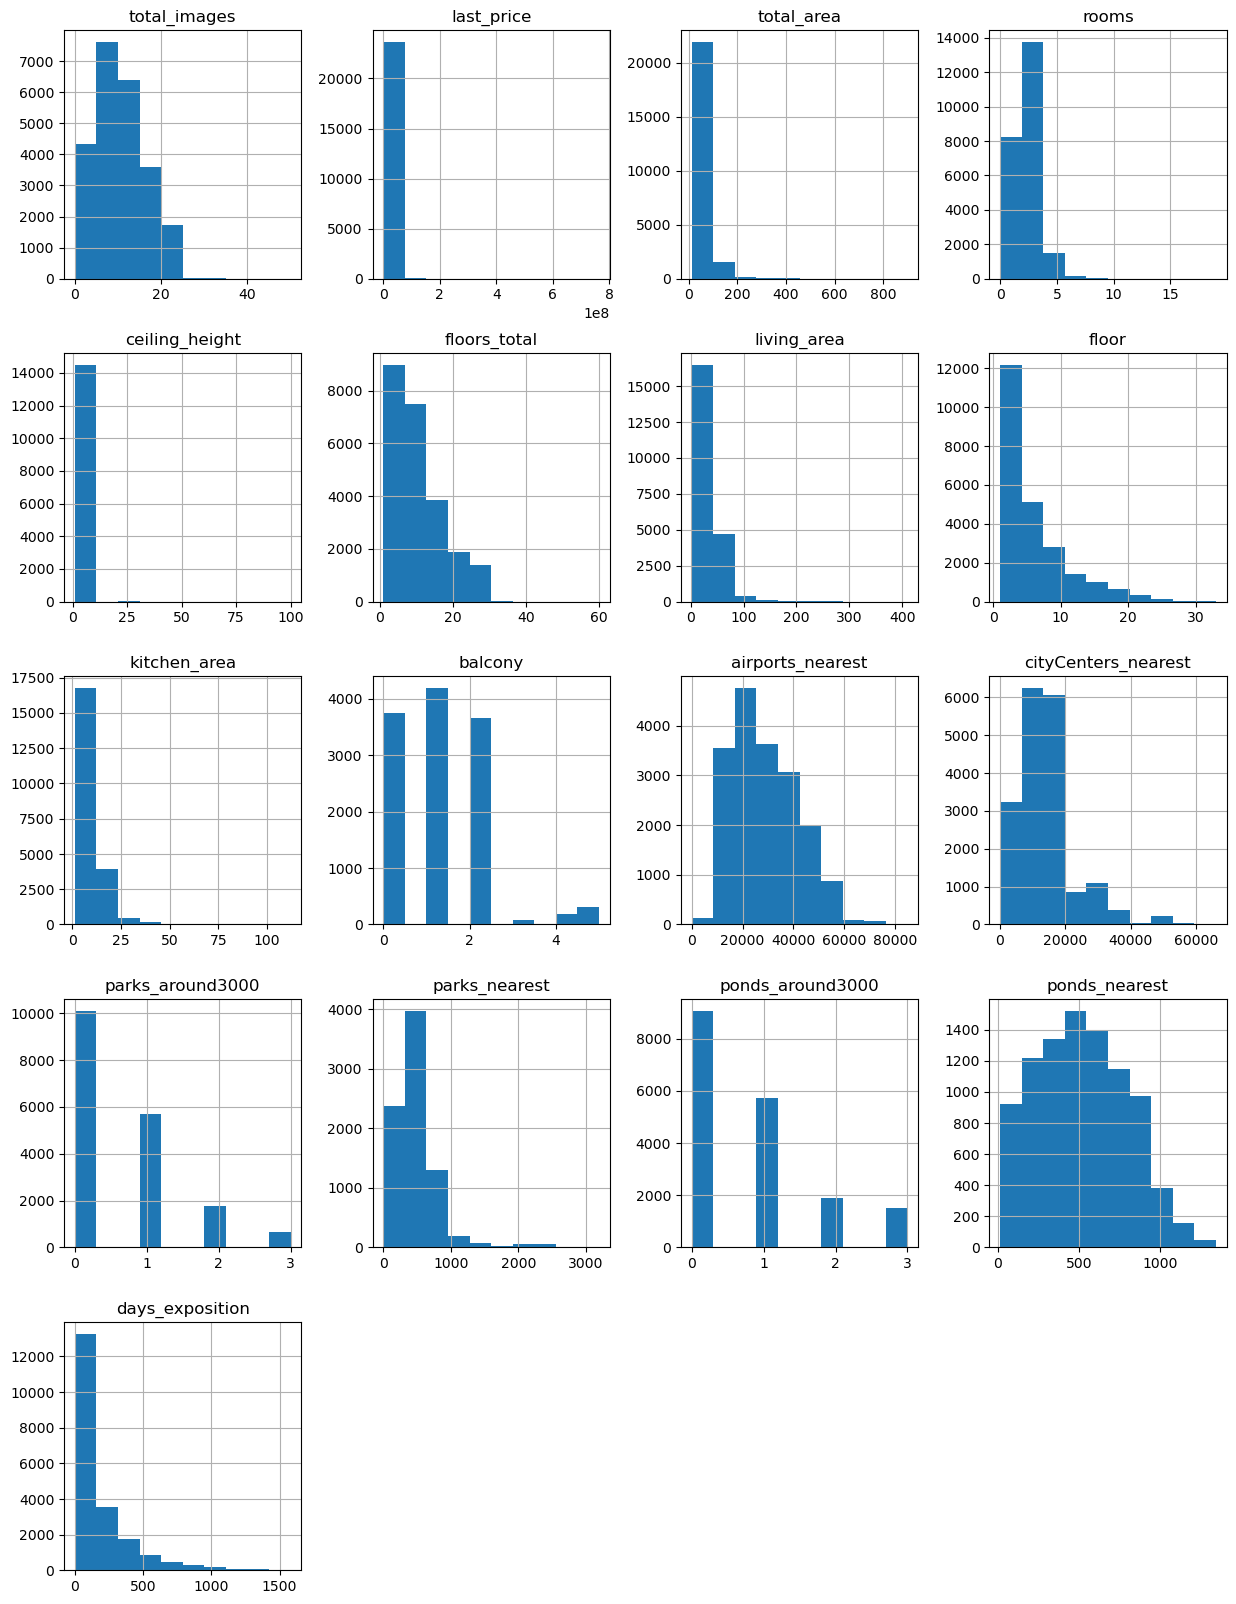

In [20]:
data.hist(figsize=(15, 20))

## Предобработка данных

### Выведем на экран общую информацию о типах данных в файле

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [22]:
#приведем к змеиному регистру название столбца 'cityCenters_nearest'
data = data.rename(columns={'cityCenters_nearest': 'city_center_nearest'})

### Устранение редких и выбивающихся значений (аномалий)

In [23]:
data.describe() #выведем на экран статистические показатели значений в столбцах

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


**При изучении таблицы выше вызывают подозрения значения:**
- общая площадь 900 кв.м
- 19 комнат
- высота потолка 100 м
- число этажей 60
- площадь кухни 112 кв.м
- 1580 дней показа объявления

**Стоит посмотреть эти строки детально, вызвав метод query.**

In [24]:
data.query('total_area>200')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
155,8,96000000.0,317.0,2017-07-07T00:00:00,4,3.50,3.0,183.0,3,NaN,...,NaN,1.0,Санкт-Петербург,22673.0,1771.0,2.0,508.0,3.0,366.0,62.0
464,15,66571000.0,280.3,2015-06-11T00:00:00,6,5.20,8.0,159.5,7,NaN,...,21.1,0.0,Санкт-Петербург,26316.0,6655.0,3.0,187.0,1.0,616.0,578.0
492,18,95000000.0,216.0,2017-12-05T00:00:00,4,3.00,5.0,86.0,4,NaN,...,77.0,NaN,Санкт-Петербург,21740.0,436.0,2.0,138.0,3.0,620.0,14.0
509,5,90000000.0,225.0,2016-06-26T00:00:00,6,NaN,4.0,134.0,2,NaN,...,19.5,2.0,Санкт-Петербург,32864.0,5720.0,0.0,NaN,2.0,519.0,416.0
521,20,25717300.0,230.1,2015-01-21T00:00:00,3,NaN,3.0,130.0,1,NaN,...,26.1,1.0,Пушкин,16877.0,29030.0,2.0,676.0,3.0,278.0,1441.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23005,20,30750000.0,297.5,2018-09-09T00:00:00,6,3.14,4.0,181.8,2,NaN,...,21.9,NaN,Санкт-Петербург,20630.0,1229.0,3.0,189.0,3.0,40.0,42.0
23281,20,24800000.0,231.2,2015-01-21T00:00:00,6,3.10,5.0,99.8,4,NaN,...,27.4,NaN,Санкт-Петербург,21480.0,2453.0,3.0,75.0,1.0,795.0,NaN
23327,19,34400000.0,215.0,2019-03-15T00:00:00,5,2.75,4.0,82.4,4,NaN,...,40.1,NaN,Санкт-Петербург,37268.0,15419.0,0.0,NaN,0.0,NaN,NaN
23400,17,30000000.0,213.0,2017-09-28T00:00:00,7,3.40,5.0,151.4,5,NaN,...,30.8,NaN,Санкт-Петербург,21146.0,1225.0,2.0,342.0,3.0,30.0,299.0


**Вывод: такая недвижимость имеет место быть, большой площади соответсвует большое количество комнат, большой метраж кухни. Это редкие значения, ошибки в них нет, но для исследовательского анализа подобные эксклюзивные данные нам не нужны, удалим их из датафрейма. Начиная с каких значений удалять, обратимся к диаграмме размаха.**

<Axes: >

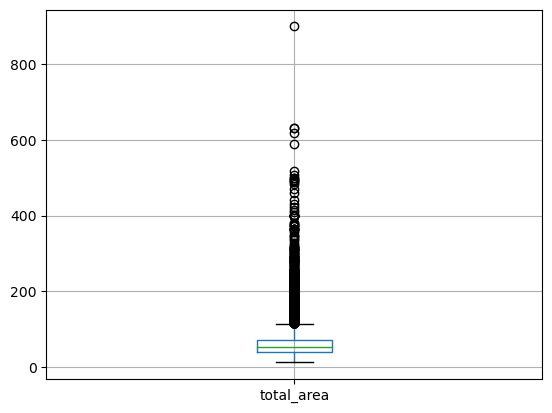

In [25]:
import matplotlib.pyplot as plt
data.boxplot(column='total_area')

In [26]:
#убираем все строки, где общая площадь превышает 200 кв.м 
data = data[data.total_area < 200]

<Axes: >

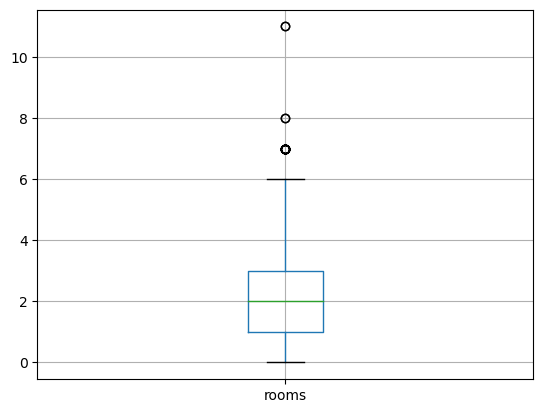

In [27]:
data.boxplot(column='rooms') 

In [28]:
data.query('rooms>8')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
648,3,17500000.0,183.7,2018-07-01T00:00:00,11,3.40,7.0,138.8,7,NaN,...,13.3,NaN,Санкт-Петербург,23606.0,3148.0,0.0,NaN,0.0,NaN,NaN
9688,8,33000000.0,194.1,2017-02-07T00:00:00,11,3.43,5.0,129.0,2,NaN,...,11.9,NaN,Санкт-Петербург,21469.0,1015.0,1.0,686.0,2.0,66.0,813.0


In [29]:
#убираем все строки, где количество комнат превышает 9 
data = data[data.rooms < 9]

In [30]:
# посмотрим строки с высотой потолка > 4м
data.query('ceiling_height > 4') 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
154,1,8200000.0,80.0,2018-11-06T00:00:00,3,4.15,3.0,44.2,2,NaN,...,12.2,NaN,Санкт-Петербург,20562.0,3167.0,2.0,344.0,1.0,838.0,38.0
355,17,3600000.0,55.2,2018-07-12T00:00:00,2,25.00,5.0,32.0,2,False,...,NaN,2.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
1053,13,550000.0,29.0,2018-02-01T00:00:00,1,5.00,3.0,NaN,1,False,...,NaN,NaN,Бокситогорск,NaN,NaN,NaN,NaN,NaN,NaN,6.0
1129,20,6695000.0,36.9,2018-09-28T00:00:00,1,4.06,5.0,22.0,2,NaN,...,7.2,NaN,Санкт-Петербург,21725.0,2990.0,1.0,596.0,1.0,866.0,110.0
2639,17,4850000.0,59.7,2017-11-18T00:00:00,3,4.19,5.0,46.3,4,NaN,...,6.4,1.0,Санкт-Петербург,42964.0,15468.0,0.0,NaN,0.0,NaN,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22055,2,8550000.0,75.1,2017-08-09T00:00:00,3,4.20,6.0,52.5,3,NaN,...,8.0,NaN,Санкт-Петербург,23060.0,2602.0,1.0,584.0,0.0,NaN,477.0
22309,20,5300000.0,45.0,2017-09-30T00:00:00,1,10.30,16.0,15.5,15,NaN,...,NaN,NaN,Санкт-Петербург,36353.0,11936.0,2.0,440.0,2.0,450.0,136.0
22336,19,9999000.0,92.4,2019-04-05T00:00:00,2,32.00,6.0,55.5,5,False,...,16.5,4.0,Санкт-Петербург,18838.0,3506.0,0.0,NaN,3.0,511.0,NaN
22869,0,15000000.0,25.0,2018-07-25T00:00:00,1,100.00,5.0,14.0,5,True,...,11.0,5.0,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0


**Странно наблюдать высокие потолки >4 м в многоквартирных домах. Вероятнее всего, что в данных ошибка, заменим в этих строках значения на медианные.**

<Axes: >

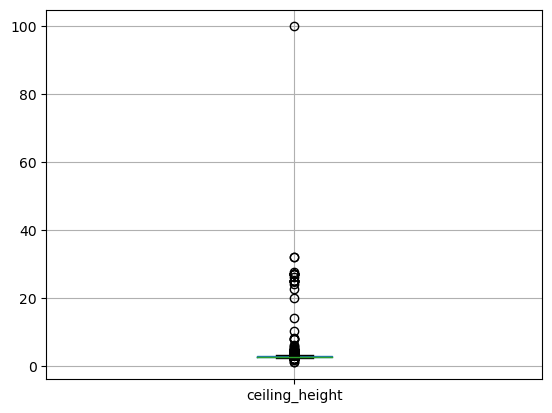

In [31]:
data.boxplot(column='ceiling_height') # построим график с усами, оценим межквартильных размах

<Axes: >

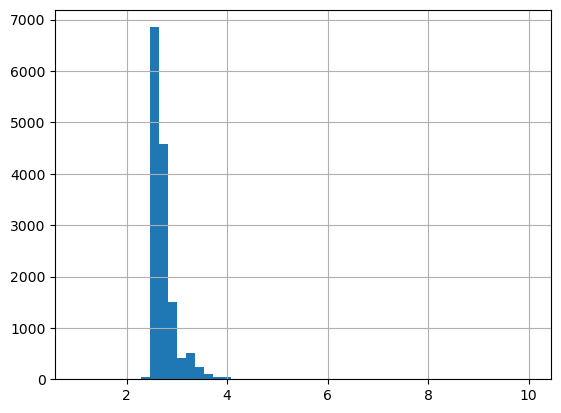

In [32]:
def ceiling_height(height):
    if height > 10: # для коррекции строк датафрейма, где вероятно пользователи ошиблись на порядок
        return height / 10
    elif height > 4:
        return data['ceiling_height'].median()
    elif height < 2:
        return 2
    return height
    
data['ceiling_height'] = data['ceiling_height'].apply(ceiling_height)

data['ceiling_height'].hist(bins=50)

In [33]:
# Код ревьюера
data.update(data[(data['ceiling_height'] >= 20) & (data['ceiling_height'] <= 36)]['ceiling_height']/10)

In [34]:
data.query('floors_total > 37') #самый высокий дом в СПб - 37 этажей, все, что выше, можно смело удалять.

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2253,12,3800000.0,45.5,2018-06-28T00:00:00,2,2.88,60.0,27.4,4,NaN,...,7.4,NaN,Кронштадт,67763.0,49488.0,2.0,342.0,3.0,614.0,166.0
16731,9,3978000.0,40.0,2018-09-24T00:00:00,1,2.65,52.0,10.5,18,NaN,...,14.0,NaN,Санкт-Петербург,20728.0,12978.0,1.0,793.0,0.0,NaN,45.0


In [35]:
data = data[data.floors_total<38] #удалим аномальные значения

<Axes: >

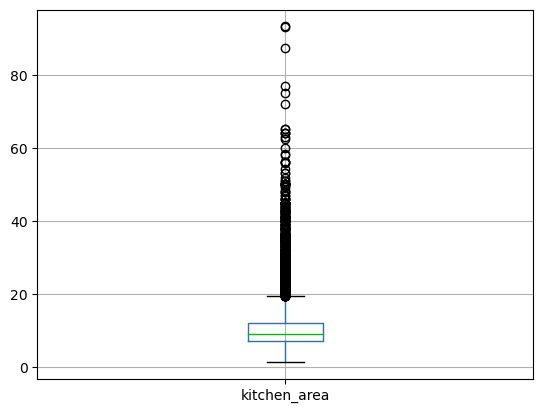

In [36]:
data.boxplot(column='kitchen_area') # посмотрим межквартильный размах для площади кухни

In [37]:
data.query('kitchen_area>20')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
51,7,45000000.0,161.00,2017-10-17T00:00:00,3,3.20,8.0,38.00,4,NaN,...,50.00,NaN,Санкт-Петербург,32537.0,6589.0,0.0,NaN,3.0,99.0,541.0
110,6,3850000.0,72.30,2017-09-29T00:00:00,2,NaN,3.0,27.40,2,NaN,...,23.60,0.0,деревня Пикколово,NaN,NaN,NaN,NaN,NaN,NaN,45.0
121,20,33000000.0,180.00,2017-02-17T00:00:00,3,2.90,9.0,86.00,8,False,...,24.00,4.0,Санкт-Петербург,25689.0,4264.0,1.0,633.0,0.0,NaN,144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23382,2,15000000.0,150.90,2016-07-04T00:00:00,4,3.67,4.0,98.20,3,NaN,...,23.90,0.0,Санкт-Петербург,21204.0,2180.0,3.0,105.0,1.0,614.0,455.0
23395,4,40000000.0,188.00,2017-05-29T00:00:00,6,NaN,6.0,109.51,4,NaN,...,31.30,0.0,Санкт-Петербург,23390.0,2254.0,2.0,425.0,1.0,62.0,30.0
23507,4,7360000.0,73.83,2018-06-23T00:00:00,2,NaN,21.0,31.65,17,NaN,...,21.55,NaN,Санкт-Петербург,35129.0,16293.0,0.0,NaN,1.0,475.0,103.0
23549,5,19600000.0,184.00,2016-04-21T00:00:00,3,3.00,19.0,55.70,19,False,...,24.50,5.0,Санкт-Петербург,18995.0,4837.0,0.0,NaN,0.0,NaN,205.0


In [38]:
data = data[data.kitchen_area<20] # оставим в датафрейме только недвижимость с площадью кухни менее 20 м

### Работа с дубликатами в данных

In [39]:
data.duplicated().sum() #убедимся, что в данных нет явных строк-дубликатов

0

In [40]:
data['locality_name'].unique() #выведем на экран уникальные значения столбца['locality_name'] - названия населенных пунктов 

array(['посёлок Шушары', 'Санкт-Петербург', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Колпино', 'Гатчина',
       'поселок Мурино', 'деревня Фёдоровское', 'Выборг', 'Кронштадт',
       'Кировск', 'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск', 'Всеволожск',
       'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'деревня Куттузи', 'посёлок Аннино', 'деревня Заклинье',
       'поселок Торковичи', 'поселок Первомайское', 'Красное Село',
       'посёлок Понтонный', 'деревня Старая', 'деревня Лесколово',
       'село Путилово', 'Ивангород', 'Сланцы', 'Шлиссельбург',
       'Сясьстрой', 'Никольское', 'Зеленогорск', 'Сосновый Бор',
       'поселок Новый Свет', 'деревня

In [41]:
#уберем названия типов населенных пунктов, а также применим метод .str.strip(), 
#чтобы удалить образовавшиеся по краям пробелы
word_list = [
    'поселок ', 'деревня ', 'посёлок ', 'поселок городского типа ', 'городского типа ', 'городской ', 
    'садовое товарищество ', 'садоводческое некоммерческое товарищество ', 'село', 'станции ', 'коттеджный'
]
name = ''
for word in word_list:
    data['locality_name'] = data['locality_name'].replace(word, name, regex = True).str.strip()
    
data['locality_name'].unique()

array(['Шушары', 'Санкт-Петербург', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Колпино', 'Гатчина', 'Фёдоровское', 'Выборг', 'Кронштадт',
       'Кировск', 'Новое Девяткино', 'Металлострой', 'Лебяжье',
       'Сиверский', 'Молодцово', 'Кузьмоловский', 'Новая Ропша',
       'Павловск', 'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск',
       'Сестрорецк', 'Куттузи', 'Аннино', 'Заклинье', 'Торковичи',
       'Первомайское', 'Красное Село', 'Понтонный', 'Старая', 'Лесколово',
       'Путилово', 'Ивангород', 'Сланцы', 'Шлиссельбург', 'Сясьстрой',
       'Никольское', 'Зеленогорск', 'Сосновый Бор', 'Новый Свет',
       'Оржицы', 'Кальтино', 'Романовка', 'Бугры', 'Рощино', 'Кириши',
       'Луга', 'Волосово', 'Отрадное', 'Павлово', 'Оредеж', 'Красный Бор',
       'Коммунар', 'Молодёжное', 'Победа', 'Нурма', 'Синявино',
       'Стрельна', 'Бокситогорск', 'Александровская', 'Лопухинка',
       'Терволово', 'Советский', 'Подпорожь

In [42]:
data['locality_name'].unique()

array(['Шушары', 'Санкт-Петербург', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Колпино', 'Гатчина', 'Фёдоровское', 'Выборг', 'Кронштадт',
       'Кировск', 'Новое Девяткино', 'Металлострой', 'Лебяжье',
       'Сиверский', 'Молодцово', 'Кузьмоловский', 'Новая Ропша',
       'Павловск', 'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск',
       'Сестрорецк', 'Куттузи', 'Аннино', 'Заклинье', 'Торковичи',
       'Первомайское', 'Красное Село', 'Понтонный', 'Старая', 'Лесколово',
       'Путилово', 'Ивангород', 'Сланцы', 'Шлиссельбург', 'Сясьстрой',
       'Никольское', 'Зеленогорск', 'Сосновый Бор', 'Новый Свет',
       'Оржицы', 'Кальтино', 'Романовка', 'Бугры', 'Рощино', 'Кириши',
       'Луга', 'Волосово', 'Отрадное', 'Павлово', 'Оредеж', 'Красный Бор',
       'Коммунар', 'Молодёжное', 'Победа', 'Нурма', 'Синявино',
       'Стрельна', 'Бокситогорск', 'Александровская', 'Лопухинка',
       'Терволово', 'Советский', 'Подпорожь

## Работа с пропусками в данных 
Определим, в каких столбцах есть пропуски:

In [43]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           7413
floors_total                0
living_area               383
floor                       0
is_apartment            17727
studio                      0
open_plan                   0
kitchen_area                0
balcony                  9314
locality_name              34
airports_nearest         4714
city_center_nearest      4696
parks_around3000         4695
parks_nearest           13468
ponds_around3000         4695
ponds_nearest           12639
days_exposition          2694
dtype: int64

**Обнаружили пропуски в столбцах:** 
- 'ceiling_height'
- 'living_area'
- 'is_apartment'
- 'kitchen_area'
- 'balcony'
- 'locality_name'
- 'airports_nearest'
- 'city_сenter_nearest '
- 'parks_around3000'
- 'ponds_nearest'
- 'days_exposition'.

**1. Работа с пропусками в столбце 'ceiling_height'**

In [44]:
data[data['ceiling_height'].isna()] #выведем на экран строки с пропусками в столбце ['ceiling_height']

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
5,10,2890000.0,30.4,2018-09-10T00:00:00,1,NaN,12.0,14.4,5,NaN,...,9.1,NaN,Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.3,2017-11-02T00:00:00,1,NaN,26.0,10.6,6,NaN,...,14.4,1.0,Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.6,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23676,19,3550000.0,36.4,2016-06-08T00:00:00,1,NaN,16.0,14.9,13,NaN,...,9.3,0.0,Санкт-Петербург,32228.0,11884.0,1.0,701.0,0.0,NaN,70.0
23687,6,3200000.0,39.0,2017-12-16T00:00:00,1,NaN,9.0,20.0,6,NaN,...,11.0,2.0,Санкт-Петербург,40837.0,16704.0,0.0,NaN,0.0,NaN,38.0
23690,3,5500000.0,52.0,2018-07-19T00:00:00,2,NaN,5.0,31.0,2,NaN,...,6.0,NaN,Санкт-Петербург,20151.0,6263.0,1.0,300.0,0.0,NaN,15.0
23692,2,1350000.0,30.0,2017-07-07T00:00:00,1,NaN,5.0,17.5,4,NaN,...,6.0,NaN,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0


In [45]:
# после преобразования аномальных значений заполним пропуски в столбце 'ceiling_height' медианным значением
print('Медианное значение высоты потолка:', data['ceiling_height'].median()) 
data['ceiling_height'] = data['ceiling_height'].fillna(value=data['ceiling_height'].median())

Медианное значение высоты потолка: 2.63


Пропуски в столбце "высота потолка" могли возникнуть из-за сбоя при выгрузке. 

**2. Работа с пропусками в столбце 'floors_total'**

После удаления аномальных значений в предыдущем разделе, пропусков не осталось

In [46]:
# изначально планировалось заполним пропуски в столбце floors_total значением floor
data.loc[data['floors_total'].isnull(), 'floors_total'] = data.loc[data['floors_total'].isnull(), 'floor']

**3. Работа с пропусками в столбце 'living_area'**

In [47]:
data['living_area'].isna().sum()

383

Пропуски в столбце "жилая площадь" могли возникнуть из-за сбоя при выгрузке.  

In [49]:
# найдем соотношение медианной общей площади к медианной жилой:
total_median_to_living_median_proportion = data['total_area'].median()/(data['living_area'].median())

# заполним пропуски в столбце living_area отношением общей площади к найденному соотношению:
data['living_area'] = data['living_area'].fillna(value=data['total_area']/total_median_to_living_median_proportion)

**4. Работа с пропусками в столбце 'is_apartment'**

Апартаменты - это отдельный тип жилья, куда нельзя прописать и где свои тарифы и правила жкх, это могут быть как жилые помещения так и офисы. Для этого поля у нас стоит True у части значений, а у остальных пропуски. Можем сделать вывод, что если квартира не является апартаментами, то пользователи при выставлении объявления с квартирой просто не заполняют это поле, поэтому все пропуски можно заполнить значением False 

In [50]:
data['is_apartment'] = data['is_apartment'].fillna(value=False)
data['is_apartment'].isna().sum()

0

**5. Работа с пропусками в столбце 'kitchen_area'**

Изучив строки {[data[data['kitchen_area'].isnull()]]}, где не указан метраж кухни видим количество комнат >1, следовательно, можно предположить, что данные пропущены случайно, ввиду технического сбоя при выгрузке, а не потому, что, к примеру, в квартире-студии нет кухни. Таких строк менее 1%, можно заполнить их медианой. 

In [51]:
# найдем соотношение медианной общей площади к медианной площади кухни. 
total_median_to_kitchen_median_proportion = data['total_area'].median()/(data['kitchen_area'].median())

# заполним пропуски в столбце kitchen_area отношением общей площади к найденному соотношению.
data['kitchen_area'] = data['kitchen_area'].fillna(value=data['total_area']/total_median_to_kitchen_median_proportion)

In [52]:
#print('Медианное значение метража кухни:', data['kitchen_area'].median())
#data['kitchen_area'] = data['kitchen_area'].fillna(value=data['kitchen_area'].median())
#data['kitchen_area'].isna().sum() #убедимся в отсутствии пропусков

Однако, можно оставить пропуски как есть, во-первых, потому что их 1%, то есть незначительное количество. Во-вторых, ниже в исследовании видим, что заполенные пропуски увеличивают пик на гистограмме на уровке 9-10 кв.м.

**6. Работа с пропусками в столбце 'balcony'**

In [53]:
data['balcony'].isna().sum() # оценим количество пропусков в столбце 

9314

In [54]:
# предположим, что при отсутствии данных в столбце 'balcony', их количество равно 0:
data['balcony'] = data['balcony'].fillna(0)  

Пропуски в столбце балконов вероятнее всего возникли потому, что балконов нет и пользователи не заполняли эту колонку

**7. Работа с пропусками в столбце 'locality_name'**

In [55]:
data['locality_name'].isna().sum() # оценим количество пропусков в столбце 

34

In [56]:
#Имеем 34 строки данных с пропусками, можно заменить пропуск на 'unknown'
data['locality_name'] = data['locality_name'].fillna('unknown')

Строки с пропусками могли возникнуть из-за технического сбоя, их решила не удалять, т.к. в них нет аномальных значений, данные могут пригодиться для анализа. 

**8. Работа с пропусками в столбце 'city_center_nearest'**

In [57]:
data['city_center_nearest'].isna().sum() # оценим количество пропусков в столбце 

4696

In [58]:
# проверим, есть ли пропуски в столбце airports_nearest при условии выбора нас.пункта Санкт-Петербург:
data[data['city_center_nearest'].isna() & data['locality_name']=='Санкт-Петербург']

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Всего пропусков 4696, но при условии выбора нас.пункта Санкт-Петербург их нет, следовательно пропуск возник при заполнении данных недвижимости для пригорода, это картографические данные, которые заполняются автоматически. Строки с пропусками придется удалить, т.к. далее нам нужно будет переводить из м в км, а делить значения NaN нельзя, а также нам нужно провести исследование зависимости цены недвижимости от расстояния от центра города только для СПб. 

<div class="alert alert-success">

Строки с пропусками не будем удалять, т.к. иначе мы потеряем 20% данных.
   
   

</div>

<div class="alert alert-success">

Заменим пропуски маркерной заглушкой "100 000" (максимальное значение датасета 65000 м), это нам нужно для того, чтобы м перевести в км, а затем в целочисленный тип, а c NaN это не получится.
   
   

</div>

In [60]:
data['city_center_nearest'] = data['city_center_nearest'].fillna(value=100000)

**9. Работа с пропусками в столбце 'airports_nearest'**

In [61]:
data['airports_nearest'].isna().sum() # оценим количество пропусков в столбце 

4714

In [62]:
# проверим, есть ли пропуски в столбце airports_nearest при условии выбора нас.пункта Санкт-Петербург:
data[data['airports_nearest'].isna() & data['locality_name']=='Санкт-Петербург']

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Всего пропусков 4714, но при условии выбора нас.пункта Санкт-Петербург их нет, следовательно пропуск возник при заполнении данных недвижимости для пригорода, это картографические данные, аэропорта в маленьком населенном пункте просто нет. Пропуски удалять не будем, оставим как есть. 

**10. Работа с пропусками в столбце 'parks_around3000'**

In [63]:
data['parks_around3000'].isna().sum() # оценим количество пропусков в столбце 

4695

In [64]:
# выведем на экран строки с пропусками при условии 'locality_name'=='Санкт-Петербург'
data[data['parks_around3000'].isna() & data['locality_name']=='Санкт-Петербург']

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Всего пропусков 4695, но при условии выбора нас.пункта Санкт-Петербург их нет, следовательно пропуск возник при заполнении данных недвижимости для пригорода, это картографические данные, можем предположить, что на карте данного населенного пункта нет парков.

In [65]:
# сделаем вывод, что данные отсутствуют, т.к это небольшой населенный пункт, где нет парков. Заменим пропуски на 0
data['parks_around3000'] = data['parks_around3000'].fillna(0)

**11. Работа с пропусками в столбце 'ponds_around3000'**

In [66]:
data['ponds_around3000'].isna().sum() # оценим количество пропусков в столбце 

4695

In [67]:
# выведем на экран строки с пропусками при условии 'locality_name'=='Санкт-Петербург'
data[data['ponds_around3000'].isna() & data['locality_name']=='Санкт-Петербург']

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Всего пропусков 4695, но при условии выбора нас.пункта Санкт-Петербург их нет, следовательно пропуск возник при заполнении данных недвижимости для пригорода, это картографические данные, можем предположить, что на карте данного населенного пункта нет водоемов. Заменим пропуски на 0

In [68]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

**12. Работа с пропусками в столбце 'ponds_nearest'**

In [69]:
data['ponds_nearest'].isna().sum() # оценим количество пропусков в столбце 

12639

In [70]:
# выведем на экран строки с пропусками при условии 'locality_name'=='Санкт-Петербург'
data[data['ponds_nearest'].isna() & data['locality_name']=='Санкт-Петербург']

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Всего пропусков 12663, но при условии выбора нас.пункта Санкт-Петербург их нет, следовательно пропуск возник при заполнении данных недвижимости для пригорода, это картографические данные, можем предположить, что на карте данного населенного пункта нет водоемов, следовательно нет данных о расстоянии до него. Пропуски заполнять не будем, оставим как есть.

**13. Работа с пропусками в столбце 'days_exposition'**

In [71]:
pd.set_option('display.max_rows', None)
data['days_exposition'].isna().sum() # оценим количество пропусков в столбце 

2694

In [72]:
data[data['days_exposition'].isna()].head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
7,5,7915000.0,71.6,2019-04-18T00:00:00,2,2.63,24.0,42.117647,22,False,...,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
45,17,5200000.0,50.6,2018-12-02T00:00:00,2,2.65,9.0,30.300000,7,False,...,7.0,0.0,Санкт-Петербург,30011.0,12872.0,0.0,NaN,0.0,NaN,NaN
46,17,6600000.0,52.1,2019-01-31T00:00:00,2,2.60,24.0,29.700000,9,False,...,8.3,2.0,Санкт-Петербург,15114.0,12702.0,0.0,NaN,0.0,NaN,NaN
49,1,3050000.0,30.8,2018-11-22T00:00:00,1,2.50,9.0,18.000000,7,False,...,6.0,0.0,Санкт-Петербург,45341.0,16603.0,1.0,675.0,0.0,NaN,NaN
52,20,11795000.0,136.0,2017-09-22T00:00:00,6,3.00,2.0,94.000000,2,False,...,11.0,1.0,Санкт-Петербург,16510.0,6582.0,1.0,526.0,0.0,NaN,NaN
71,20,4850000.0,57.5,2019-03-27T00:00:00,3,2.50,9.0,39.000000,8,False,...,6.2,0.0,Санкт-Петербург,33623.0,12267.0,1.0,334.0,1.0,333.0,NaN
84,11,2400000.0,43.9,2019-03-13T00:00:00,2,2.63,2.0,27.460000,1,False,...,5.2,0.0,Кировск,NaN,100000.0,0.0,NaN,0.0,NaN,NaN
87,19,4999000.0,52.0,2019-04-23T00:00:00,2,2.61,9.0,30.000000,6,False,...,9.0,2.0,Санкт-Петербург,12444.0,15035.0,0.0,NaN,1.0,881.0,NaN
88,0,1700000.0,33.1,2019-04-09T00:00:00,1,2.63,5.0,18.400000,1,False,...,6.4,0.0,Лебяжье,NaN,100000.0,0.0,NaN,0.0,NaN,NaN
101,4,3000000.0,37.0,2019-03-23T00:00:00,1,2.75,10.0,12.000000,3,False,...,13.0,0.0,Новая Ропша,NaN,100000.0,0.0,NaN,0.0,NaN,NaN


Количество пропусков в столбце 2694, чуть более 1% данных датасета. Пропуски могли возникнуть по причине технического сбоя или при выгрузке. Оставим их как есть.

In [73]:
print('Медианное значение в days_exposition:', data['days_exposition'].median())
#data['days_exposition'] = data['days_exposition'].fillna(value=data['days_exposition'].median())

Медианное значение в days_exposition: 99.0


### Изменение типов данных в столбцах 

Заменить тип данных с float64 на int64 следует в столбцах floors_total, balcony, parks_around3000, ponds_around3000, days_exposition, так как значения в них (число этажей, балконов, парков и прудов в округе, дней показа) являются целыми числами, а не дробными. Сделать это можно только тогда, когда в указанных столбцах не останется пропусков (NaN)

<div class="alert alert-block alert-info">

Данные в days_exposition не будем переводить в целочисленный тип, т.к. оставили строки с пропусками.
    
</div>

In [75]:
data['floors_total'] = data['floors_total'].astype('int')
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
#data['days_exposition'] = data['days_exposition'].astype('int') 
data['balcony'] = data['balcony'].astype('int')
data.info() # проверим, как изменился формат данных

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20169 entries, 1 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          20169 non-null  int64  
 1   last_price            20169 non-null  float64
 2   total_area            20169 non-null  float64
 3   first_day_exposition  20169 non-null  object 
 4   rooms                 20169 non-null  int64  
 5   ceiling_height        20169 non-null  float64
 6   floors_total          20169 non-null  int32  
 7   living_area           20169 non-null  float64
 8   floor                 20169 non-null  int64  
 9   is_apartment          20169 non-null  bool   
 10  studio                20169 non-null  bool   
 11  open_plan             20169 non-null  bool   
 12  kitchen_area          20169 non-null  float64
 13  balcony               20169 non-null  int32  
 14  locality_name         20169 non-null  object 
 15  airports_nearest   

<div class="alert alert-block alert-info">

Можно еще сэкономить память, изменяя типы данных. Например, дополнительно изменить их у площадей квартир с float64 на float32:
    
</div>

In [76]:
data['total_area'] = data['total_area'].astype('float32')
data['living_area'] = data['living_area'].astype('float32')
data['kitchen_area'] = data['kitchen_area'].astype('float32')
data.info()                                              

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20169 entries, 1 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          20169 non-null  int64  
 1   last_price            20169 non-null  float64
 2   total_area            20169 non-null  float32
 3   first_day_exposition  20169 non-null  object 
 4   rooms                 20169 non-null  int64  
 5   ceiling_height        20169 non-null  float64
 6   floors_total          20169 non-null  int32  
 7   living_area           20169 non-null  float32
 8   floor                 20169 non-null  int64  
 9   is_apartment          20169 non-null  bool   
 10  studio                20169 non-null  bool   
 11  open_plan             20169 non-null  bool   
 12  kitchen_area          20169 non-null  float32
 13  balcony               20169 non-null  int32  
 14  locality_name         20169 non-null  object 
 15  airports_nearest   

In [78]:
print('После предобработки в датасете осталось:', len(data) / 23699 * 100, '% данных')


После предобработки в датасете осталось: 85.10485674501034 % данных


<div class="alert alert-block alert-info">
    
Значение 80-90% достигнуто! 
    
</div>

## Добавим в таблицу новые столбцы

In [79]:
# добавим столбец с ценой за кв м
data['sq_meter_price'] = data['last_price']/data['total_area']

In [80]:
# преобразуем столбец 'date_datetime' методом pd.to_datetime
data['date_datetime'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [81]:
# создадим столбец 'weekday' - день недели публикации объявления
data['weekday'] = pd.DatetimeIndex(data['date_datetime']).weekday

In [82]:
# создадим столбец 'month' - месяц публикации объявления
data['month'] = pd.DatetimeIndex(data['date_datetime']).month

In [83]:
# создадим столбец 'year' - год публикации объявления
data['year'] = pd.DatetimeIndex(data['date_datetime']).year     

In [84]:
# создадим столбец 'floor_type' c тремя типами этажей: первый, последний, другой
def floor_type(row):
    floor =row['floor']
    floors_total= row['floors_total']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    return 'другой'
data['floor_type'] = data.apply(floor_type, axis=1) 

**Расстояние до центра города переведем из метров в  километры и округлим до целых значений:**

In [85]:
data['city_center_nearest'] = data['city_center_nearest']/1000
data['city_center_nearest'].astype('int')
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_price,weekday,month,year
count,20169.000000,2.016900e+04,20169.000000,20169.000000,20169.000000,20169.000000,20169.000000,20169.000000,20169.000000,20169.000000,...,20169.000000,20169.000000,6701.000000,20169.000000,7530.000000,17475.000000,20169.000000,20169.000000,20169.00000,20169.000000
mean,9.934404,5.538844e+06,56.388779,2.023154,2.675238,10.617234,32.645203,5.834746,9.504831,0.628440,...,34.461036,0.449353,488.336815,0.565472,525.295485,181.770873,95702.980818,2.551143,6.41772,2017.369428
std,5.594950,4.193557e+06,23.339230,0.955220,0.201199,6.516163,16.242186,4.810966,3.140516,0.971978,...,36.887134,0.728129,334.176311,0.862520,276.568292,218.986019,37155.906123,1.783773,3.46198,1.036387
min,0.000000,4.300000e+05,14.000000,1.000000,1.400000,1.000000,2.000000,1.000000,1.300000,0.000000,...,0.181000,0.000000,1.000000,0.000000,13.000000,1.000000,9615.384615,0.000000,1.00000,2014.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.600000,2.000000,7.000000,0.000000,...,11.285000,0.000000,289.000000,0.000000,305.000000,44.000000,75862.068966,1.000000,3.00000,2017.000000
50%,10.000000,4.550000e+06,51.000000,2.000000,2.630000,9.000000,30.000000,4.000000,9.000000,0.000000,...,15.118000,0.000000,456.000000,0.000000,510.000000,99.000000,93797.279019,2.000000,6.00000,2017.000000
75%,14.000000,6.400000e+06,66.500000,3.000000,2.700000,15.000000,41.470589,8.000000,11.090000,1.000000,...,35.260000,1.000000,612.000000,1.000000,733.750000,232.500000,111848.303819,4.000000,10.00000,2018.000000
max,50.000000,1.190000e+08,198.100006,8.000000,10.000000,37.000000,164.699997,33.000000,19.940001,5.000000,...,100.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,721518.997296,6.000000,12.00000,2019.000000


## Проведите исследовательский анализ данных

### Анализ данных столбца "общая площадь"

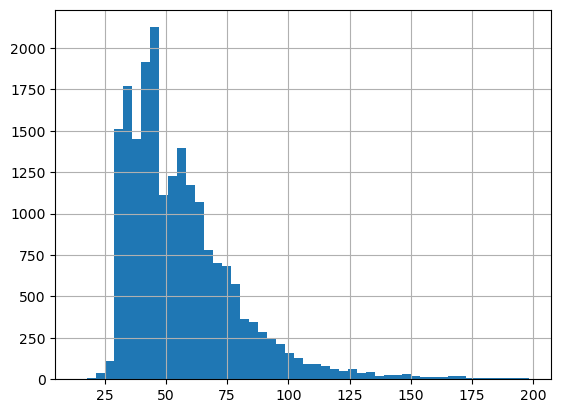

In [86]:
# Построим гистограмму столбца значений общей площади. 
data['total_area'].hist(bins=50)
plt.show()

**Наблюдаем два пика: первый соответствует площадям примерно 30-40 кв.м, второй примерно 50-60 кв.м, как правило, это 1-2 комнатные квартиры. Из этого можно сделать вывод, что недвижимости с данными площадями больше на рынке.**

### Анализ данных столбца "жилая площадь"

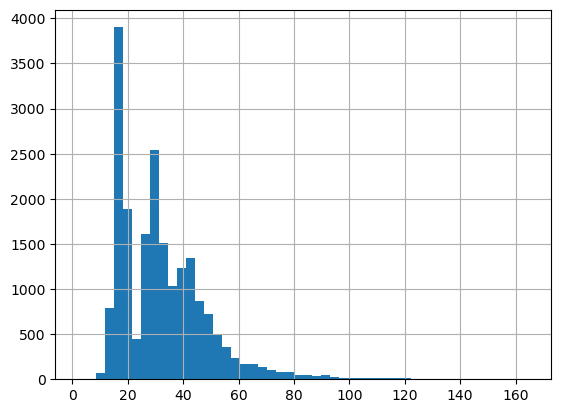

In [87]:
data['living_area'].hist(bins=50)
plt.show()

**Вывод: на гистограмме наблюдаем три пика. Первый соответсвует жилой площади 18 кв.м (однокомнатные квартиры и студии), второй 30 кв.м (двухкомнатные квартиры), третий 45 кв.м (трехкомнатные или большие двухкомнатные квартиры). Из гистограммы можем заключить, что одно- и двух-комнатных квартир в датасете больше всего.** 

### Анализ данных столбца "площадь кухни" 

Медианное значение площади кухни: 9.0


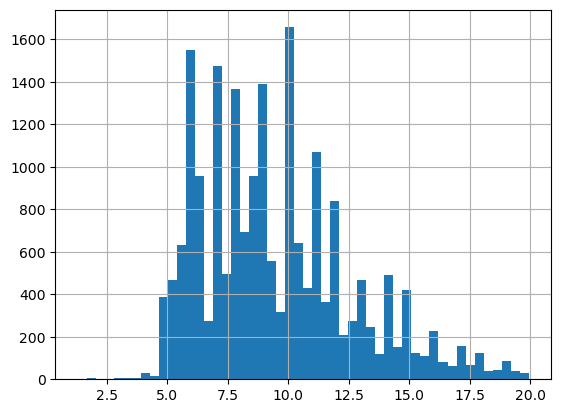

In [88]:
print('Медианное значение площади кухни:', data['kitchen_area'].median())
data['kitchen_area'].hist(bins=50)
plt.show()

**Наблюдаем пики на 6 кв.м, 7-9 кв.м и 10-11 кв.м что соответствует стандартным площадям кухни в многоквартирных домах старой планировки (хрущевки), улучшенной и новой.**

### Анализ данных  столбца "цена объекта"

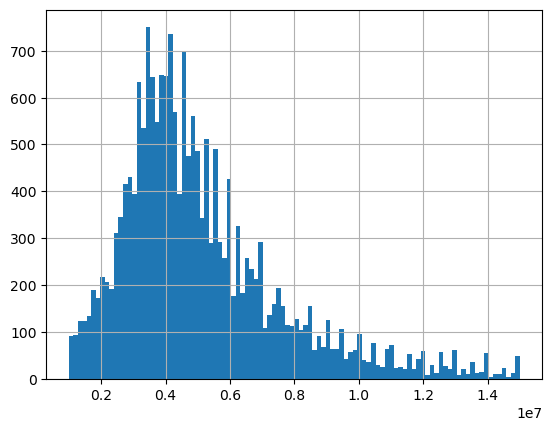

In [89]:
data['last_price'].hist(bins=100, range =(1000000, 15000000))
plt.show()

**Вывод: в датасете больше всего недвижимости стоимостью от 3 до 5 млн.руб.**

### Анализ данных  столбца "количество комнат"

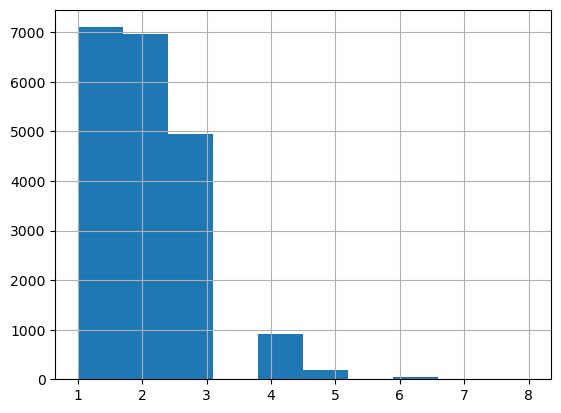

In [90]:
data['rooms'].hist()
plt.show()

**В датасете больше всего представлено недвижимости с 1 - 2 комнатами, чуть меньше с 3. 4-5-6 комнатных квартир меньше всего на рынке.**

### Анализ данных  столбца "высота потолков"

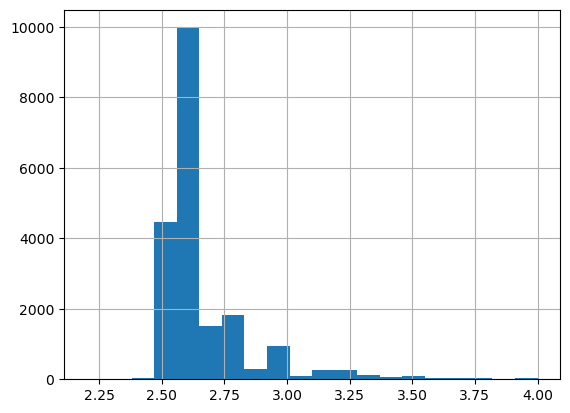

2.63

In [91]:
data['ceiling_height'].hist(bins=20, range=(2.2,4))
plt.show()
data['ceiling_height'].median()

**Вывод: самая распространенная высота потолка 2.5 - 2.65 м**

### Анализ данных  столбца "этаж квартиры"

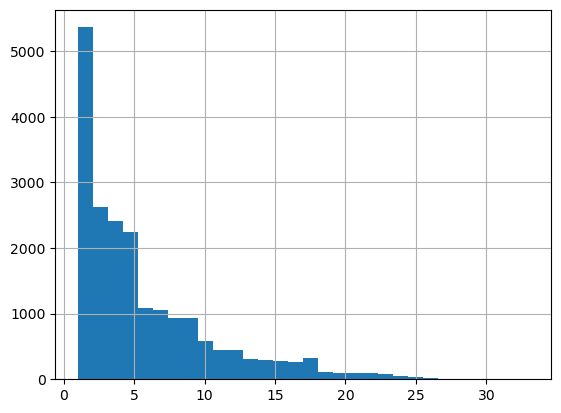

In [92]:
data['floor'].hist(bins=30)
plt.show()

**Вывод: самый большой процент недвижимости продается на 1 этаже, далее можно выделить пик с 1 по 5 этаж - пятиэтажные дома и с 1 по 9 - девятиэтажные дома. То есть больше всего в датасете представлено недвижимости в пятиэтажках, далее следуют девятиэтажки. Более высотных домов значительно меньше.**

### Анализ данных  столбца "тип этажа квартиры" («первый», «последний», «другой»)

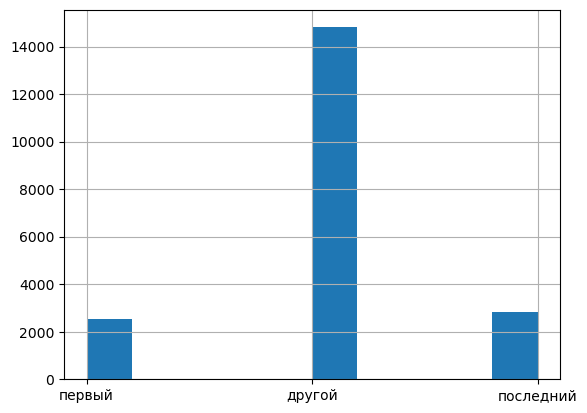

In [93]:
data['floor_type'].hist()
plt.show()

**Вывод: больше всего недвижимости представлено на промежуточных этажах, на крайних(первых и последнем) меньше и примерно одинаковое количество.**  

### Анализ данных  столбца "общее количество этажей в доме"

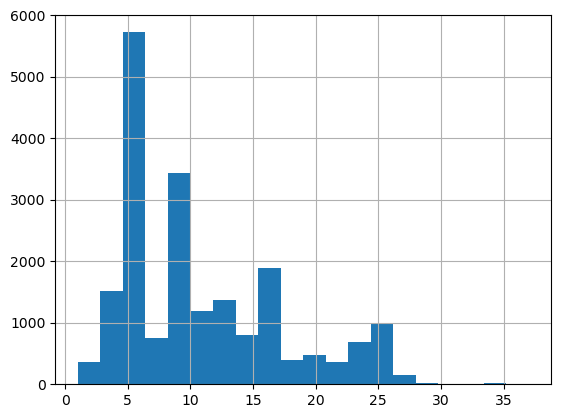

In [94]:
data['floors_total'].hist(bins=20)
plt.show()

**Вывод: на гистограмме видим отчетливые пики  трехэтажных, пятиэтажных, девятиэтажных , тринадцати и шестнадцатиэтажных домов. Больше всего в датасете пятиэтажек, девятиэтажек и шестнадцатиэтажек.**

### Анализ данных  столбца "расстояние до центра города"

In [95]:
# как мы уже выяснили на этапе предобработки, в строках, где нас.пункт Санкт-Петербург не было пропусков, а теперь, 
# соответственно, нет строк с маркерной заглушкой: 
data[(data['city_center_nearest'] == 10000) & (data['locality_name']=='Санкт-Петербург')]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_price,date_datetime,weekday,month,year,floor_type


In [96]:
data['city_center_nearest'].describe()

count    20169.000000
mean        34.461036
std         36.887134
min          0.181000
25%         11.285000
50%         15.118000
75%         35.260000
max        100.000000
Name: city_center_nearest, dtype: float64

<Axes: >

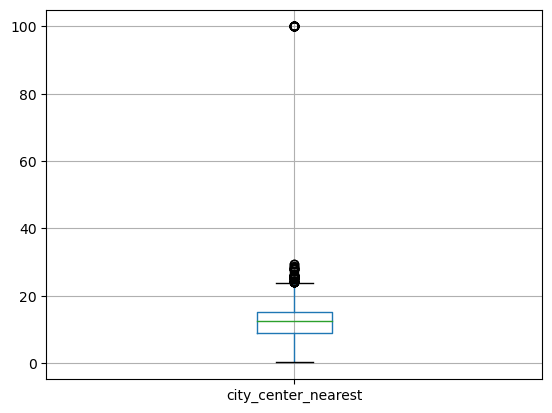

In [97]:
# отфильтруем датасет, т.к. нас интересует только СПб:
data_filtered = data.query('locality_name == "Санкт-Петербург"')
data_filtered.boxplot(column= 'city_center_nearest')

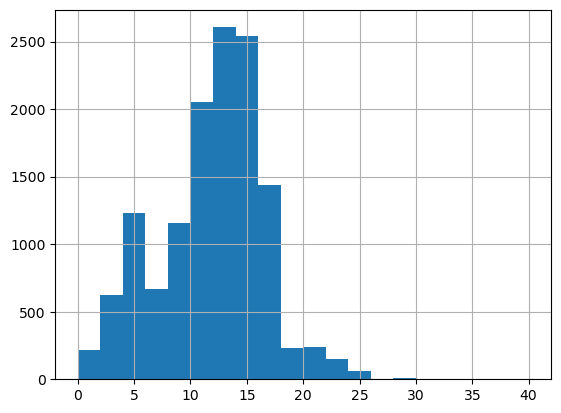

In [98]:
data_filtered['city_center_nearest'].hist(bins=20, range=(0, 40))
plt.show()

**Вывод:больше всего недвижимости в датасете находится на расстоянии 5-17 км от центра города, где в свою очередь можно выделить характерный пик в 10-17 км.**

### Анализ данных  столбца "расстояние до ближайшего аэропорта"

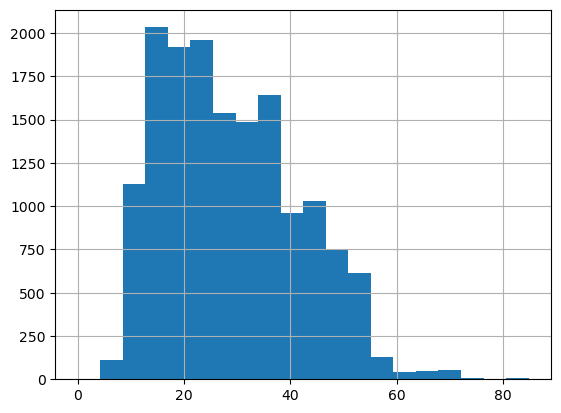

In [99]:
data['airports_nearest'] = data['airports_nearest']/1000 # переведем расстояние из м в км для удобства
data['airports_nearest'].hist(bins=20)
plt.show()

**Вывод: больше всего недвижимости в датасете находится на расстоянии от 10 до 40 км от аэропорта.**

### Анализ данных  столбца "расстояние до ближайшего парка"

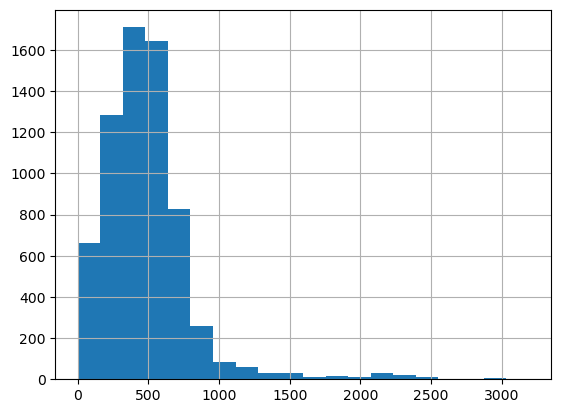

In [100]:
data['parks_nearest'] = data['parks_nearest'] # переведем расстояние из м в км для удобства
data['parks_nearest'].hist(bins=20)
plt.show()

**Вывод: Чаще всего парки находятся в радиусе 1 км, самое распространенное расстояние до парка - 500м.**

### Анализ данных  столбца "день и месяц публикации объявления"

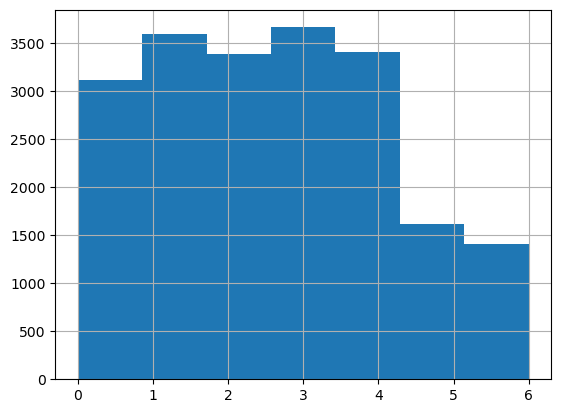

In [101]:
data['weekday'] = data['weekday'] # переведем расстояние из м в км для удобства
data['weekday'].hist(bins=7)
plt.show()

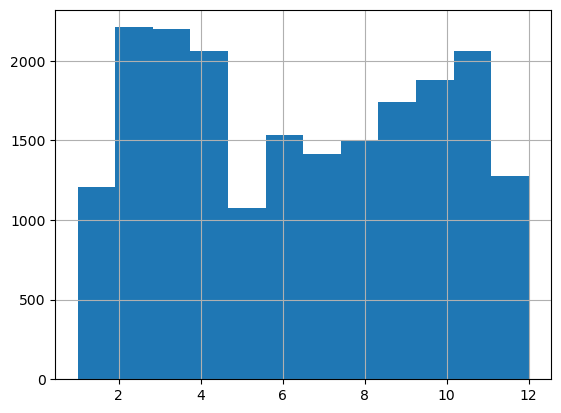

In [102]:
data['month'] = data['month'] # переведем расстояние из м в км для удобства
data['month'].hist(bins=12)
plt.show()

**Вывод: чаще всего объявления публиковались на буднях - с пн по пт, что касается месяца, то видим, что есть всплеск публикаций в феврале-апреле, затем небольшой спад в мае и плавный подъем с июня по ноябрь. В декабре и январе публикаций было мало, как в мае.**

### Исследуем, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление. 

count    17475.000000
mean       181.770873
std        218.986019
min          1.000000
25%         44.000000
50%         99.000000
75%        232.500000
max       1580.000000
Name: days_exposition, dtype: float64


<Axes: >

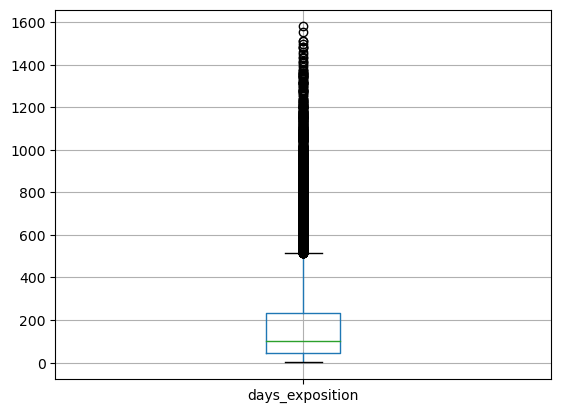

In [103]:
print(data['days_exposition'].describe())
data.boxplot(column='days_exposition')

In [104]:
print('Медианное времени показа:', data['days_exposition'].median())
print('Среднее арифметическое времени показа:', data['days_exposition'].mean())

Медианное времени показа: 99.0
Среднее арифметическое времени показа: 181.77087267525036


In [105]:
#data.query('days_exposition==555').count()

<div class="alert alert-block alert-info">
  Заглушка тоже влияет на среднее и медиану. Поэтому некорректно заполнять пропуски ни заглушкой, ни медианой. Если заполнять заглушкой, то при постороении гистограммы надо эту заглушку отфильтровывать. 
    
</div>

<Axes: >

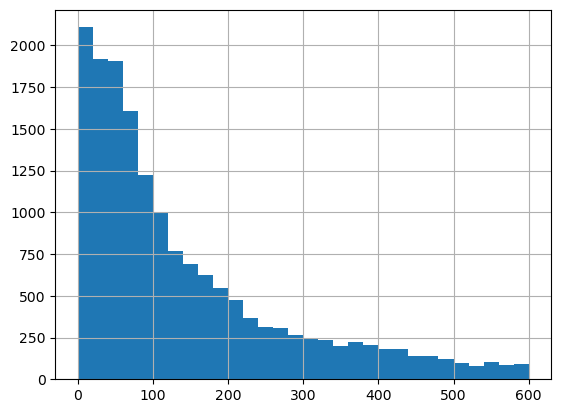

In [106]:
data['days_exposition'].hist(bins=30, range=(0, 600))

<div class="alert alert-block alert-info">
  Новый вывод: обычно продажа занимает около 100 дней (Q2= 99), то есть примерно 3 месяца. Быстрыми можно считать продажи которые лежат левее от медианы, то есть меньше 100 дней, а необычно долгими, которые на графике boxplot лежат за пределами Q3+1.5*IQR, то есть более 500 дней. Теперь выбросов не наблюдаем.
    
</div>

### Исследование факторов, которые больше всего влияют на общую (полную) стоимость объекта

5.2.1 **Исследование зависимости цены от общей площади**

<Axes: xlabel='total_area'>

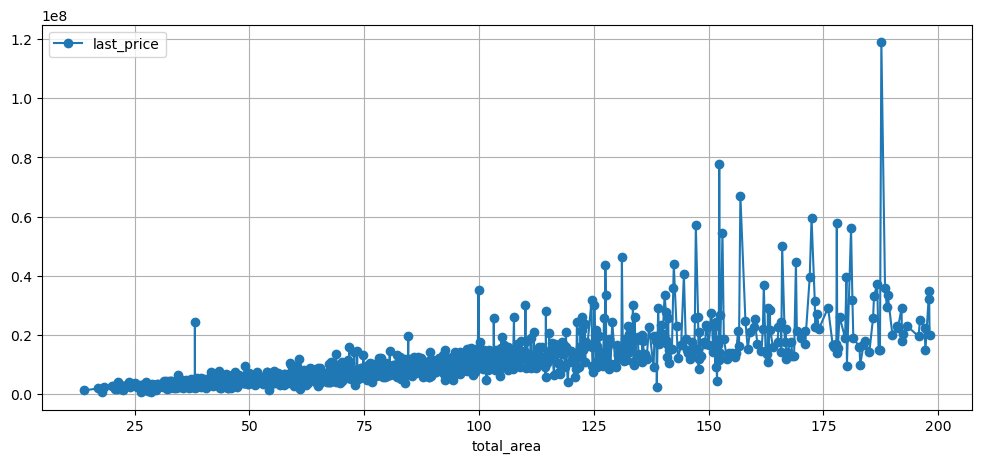

In [107]:
data.pivot_table(index='total_area', values='last_price').plot(grid=True, style ='o-', figsize=(12, 5))

In [108]:
data['last_price'].corr(data['total_area']) #рассчитаем коэфф.корреляции Пирсона

0.7185644957544773

**Вывод: наблюдаем прямопропорциональную зависимость: стоимость недвижимости увеличивается с увеличением общей площади. Коэффициент корреляции равен 0.72, что говорит о достаточно сильной связи.**

5.2.2 **Исследование зависимости цены от жилой площади** 

<Axes: xlabel='living_area'>

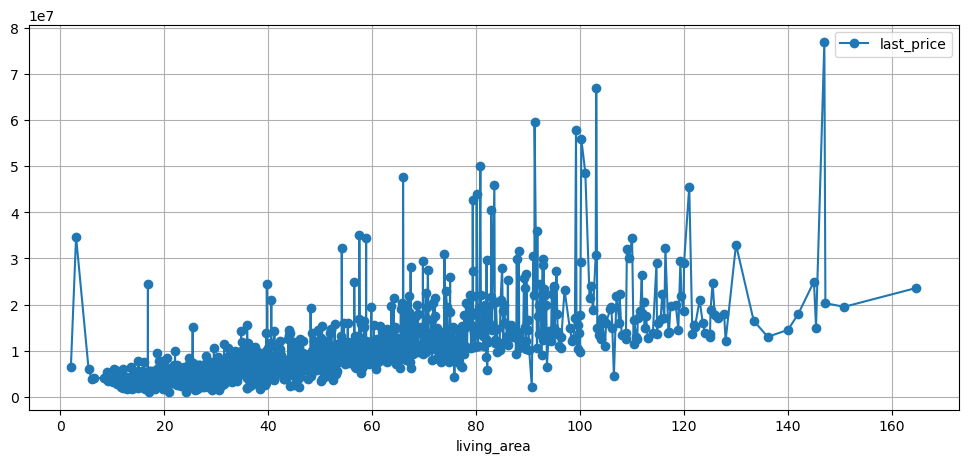

In [109]:
data.pivot_table(index='living_area', values='last_price').plot(grid=True, style ='o-', figsize=(12, 5))

In [110]:
data['last_price'].corr(data['living_area']) #рассчитаем коэфф.корреляции Пирсона

0.6348308929561235

**Вывод: наблюдаем прямопропорциональную зависимость: цена увеличивается с ростом жилой площади.Коэффициент корреляции равен 0.64, что говорит о наличии связи, однако не слишком сильной.**

5.2.3 **Исследование зависимости цены от площади кухни** 

<Axes: >

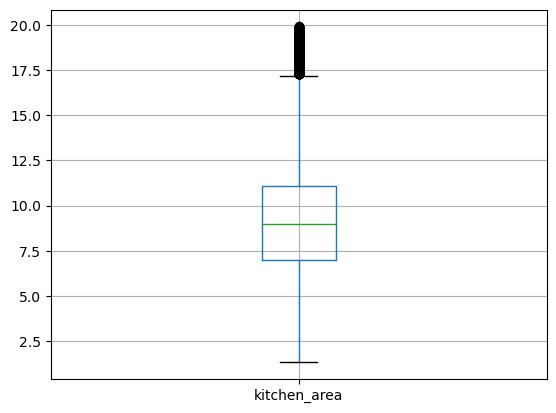

In [111]:
data.boxplot(column='kitchen_area') # выведем на экран график с усами, чтобы наглядно увидеть диаграмму размаха и понять
# с какого значения начинаются выбросы. 

<Axes: xlabel='kitchen_area'>

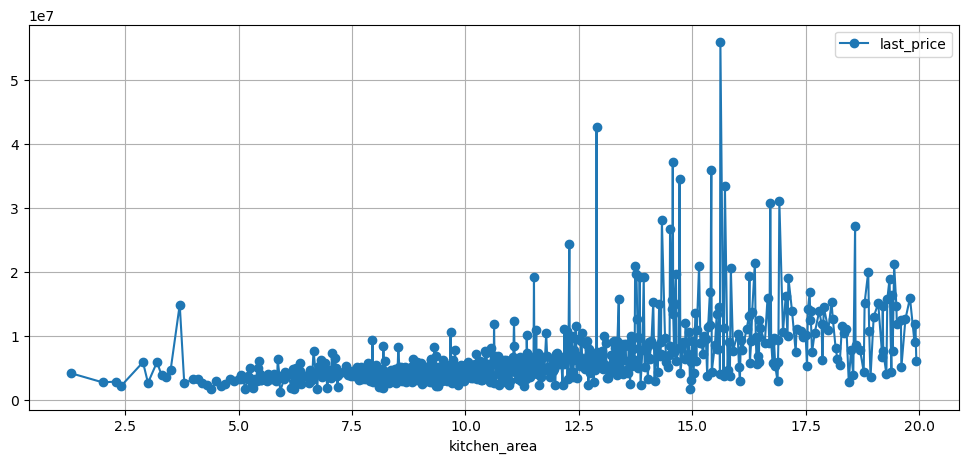

In [112]:
# по оси абсцисс ограничимся метражом кухни 20 кв.м, так как далее значения можно считать выбросами.
data.query('kitchen_area < 20').pivot_table(
    index='kitchen_area', values='last_price', aggfunc = 'mean').plot(grid=True, style ='o-', figsize=(12, 5))

In [113]:
data['last_price'].corr(data['kitchen_area']) #рассчитаем коэфф.корреляции Пирсона

0.4726472938505136

**Вывод: наблюдаем нерезкое увеличение стоимости недвижимости с увеличением площади кухни. Коэффициент корреляции равен 0,47, что говорит о наличии связи, однако не слишком сильной.**

5.2.4 **Исследование зависимости цены от количества комнат** 

In [114]:
#data.boxplot(column='rooms')  #выведем на экран график с усами, чтобы наглядно увидеть диаграмму размаха и понять
# с какого значения начинаются выбросы. 

<Axes: xlabel='rooms'>

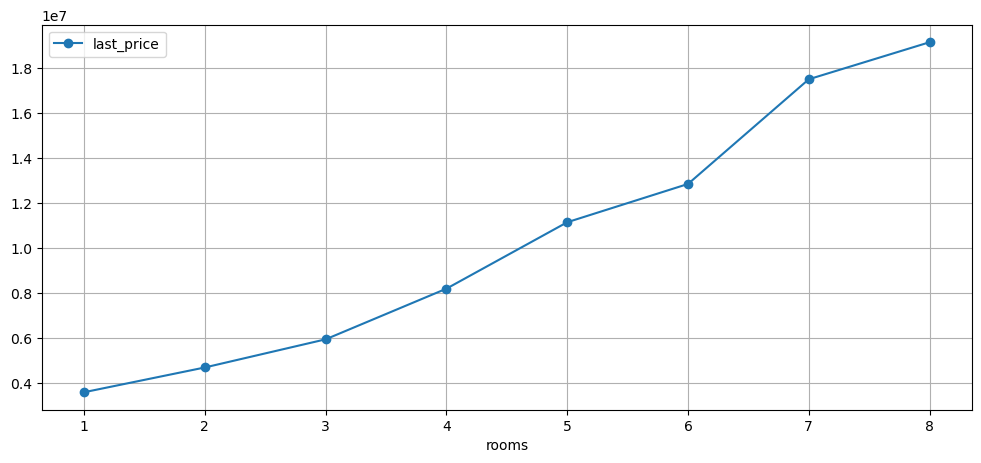

In [115]:
data.pivot_table(
    index='rooms', values='last_price', aggfunc = 'median').plot(grid=True, style ='o-', figsize=(12, 5))

In [116]:
data['last_price'].corr(data['rooms']) #рассчитаем коэфф.корреляции Пирсона

0.44027427297350785

**Вывод: по графику наблюдаем увеличение стоимости недвижимости с увеличением числа комнат. Коэфф.корреляции Пирсона равен 0,44.**

5.2.5 **Исследование зависимости цены от этажа, на котором расположена квартира** 

<Axes: xlabel='floor_type'>

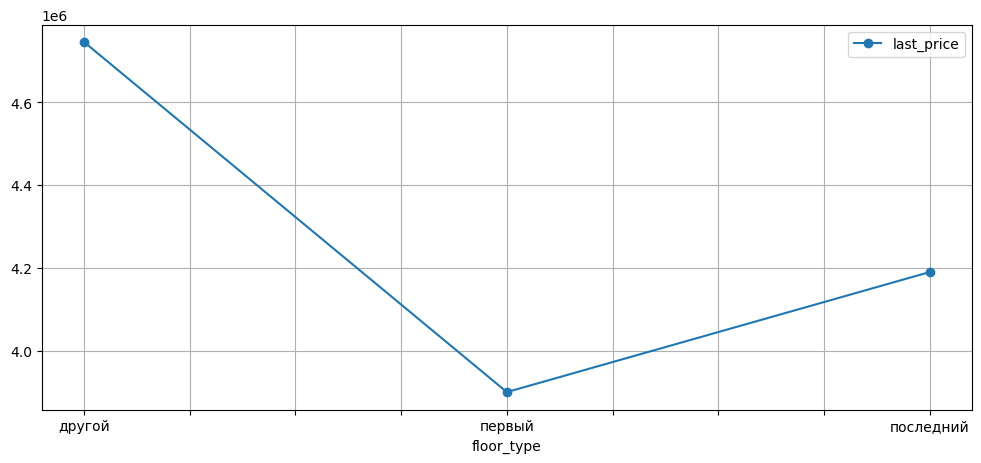

In [117]:
data.pivot_table(index='floor_type', values='last_price', aggfunc = 'median').plot(grid=True, style ='o-', figsize=(12, 5))

**Вывод: Самая дорогая недвижимость находится на промежуточных этажах, самая дешевая недвижимость - на 1ом, на последних 
этажах стоимость в 2 больше, чем на первых и в 2 меньше, чем на промежуточных. Здесь коэфф. Пирсона не может быть применен, т.к. значения в столбце 'floor_type' типа object**

5.2.6 **Исследование зависимости цены от дня размещения** 

<Axes: xlabel='weekday'>

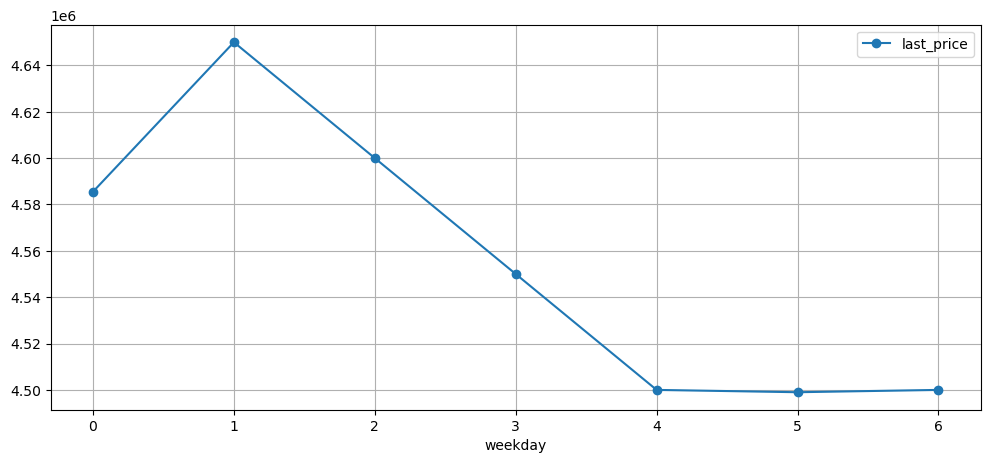

In [118]:
data.pivot_table(index='weekday', values='last_price', aggfunc = 'median').plot(grid=True, style ='o-', figsize=(12, 5))

**Вывод: наблюдаем уменьшение стоимости недвижимости в зависимости от начала недели к концу. Самая дорогая недвижимость была выложена в будние дни (пик во вторник), самая дешевая - в пятницу и выходные дни. Коэфф.Пирсона не применяется.**

5.2.7 **Исследование зависимости цены от месяца размещения** 

<Axes: xlabel='month'>

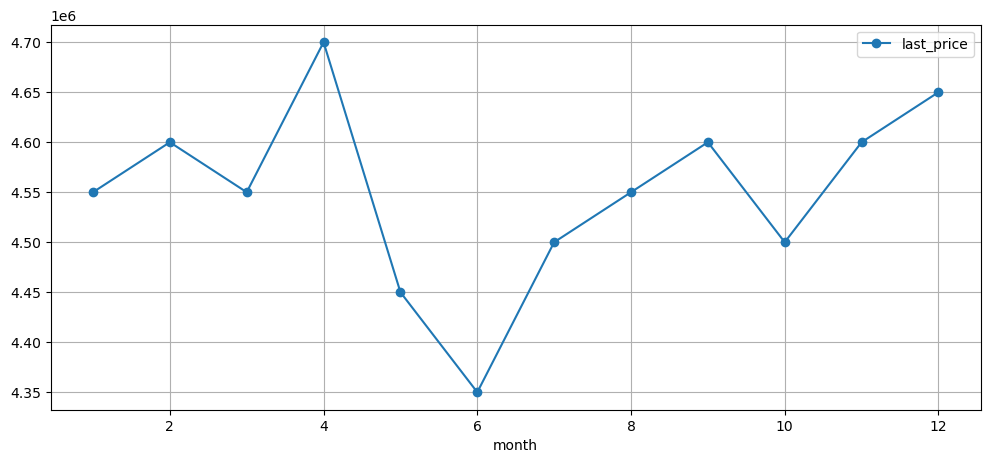

In [119]:
data.pivot_table(index='month', values='last_price', aggfunc = 'median').plot(grid=True, style ='o-', figsize=(12, 5))

**Вывод: Самая дорогая недвижимость была размещена в продаже в апреле и декабре, самая дешевая летом - в мае, июне и июле.Коэфф.Пирсона не применяется.**

5.2.8 **Исследование зависимости цены недвижимости от года размещения** 

In [120]:
data['year'].value_counts()

2018    7113
2017    7041
2019    2512
2016    2421
2015     981
2014     101
Name: year, dtype: int64

<Axes: xlabel='year'>

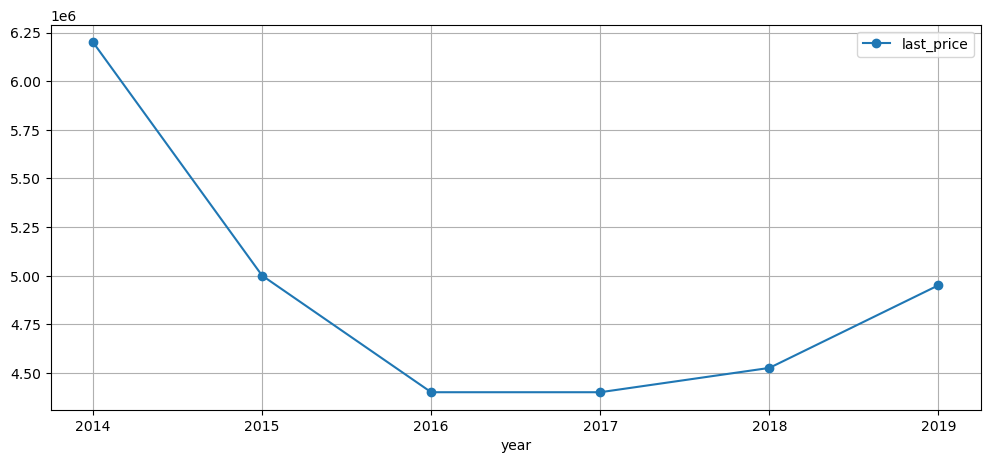

In [121]:
data.pivot_table(index='year', values='last_price', aggfunc = 'median').plot(grid=True, style ='o-', figsize=(12, 5))

**Вывод: наблюдаем спад стоимости недвижимости с 2014 до 2016 года. Однако, здесь стоит отметить, что в 2014 и 2015 размещено менее 1% объявлений от датафрейма. В 2019 году по сравнению с плато 2016-2018 г наблюдаем росто стоимости недвижимости. Коэфф.Пирсона не применяется.**

### Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце locality_name.

In [122]:
data['locality_name'].value_counts().head(10) #выведем на экран 10 насел.пунктов с наибольшим количеством объявлений

Санкт-Петербург    13259
Мурино               472
Шушары               392
Кудрово              366
Всеволожск           348
Колпино              317
Пушкин               312
Гатчина              290
Парголово            286
Выборг               192
Name: locality_name, dtype: int64

In [123]:
# cоздадим сводную таблицу самых популярных населенных пунктов и стоимости квадратгного метра недвижимости в нем.
# cделаем сортировку по убыванию стоимости
data_locality_pivot = data.query('locality_name in \
["Санкт-Петербург", "Мурино", "Шушары", "Кудрово", "Всеволожск", "Колпино",\
"Пушкин", "Гатчина", "Парголово", "Выборг" ]')\
.pivot_table(index='locality_name', values='sq_meter_price', aggfunc='mean').sort_values(by='sq_meter_price', ascending=False)

data_locality_pivot

,sq_meter_price
locality_name,
Санкт-Петербург,109824.790217
Пушкин,101537.529016
Кудрово,95632.309573
Парголово,90651.540322
Мурино,85754.130463
Шушары,78395.057601
Колпино,75145.345527
Всеволожск,68811.076453
Гатчина,68496.420173


**Вывод: самая дорогая недвижимость в Санкт-Петербурге (110 000 руб./кв.м), что предсказуемо. Далее по убыванию следуют пригороды СПб, в Выборге стоимость квадратного метра (58 000 руб./кв.м) практически в 2 раза дешевле, чем в СПб.**

### Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города.

In [124]:
# создадим сводную таблицу зависимости стоимости недвижимости от расстояния до центра города 
# data.query('locality_name=="Санкт-Петербург"').pivot_table(index='city_center_nearest', values='last_price', aggfunc='mean')

<div class="alert alert-block alert-info">
  Построим график на основе сводной таблицы, но зададим условие для фильтрации заглушки (city_center_nearest != 100). 
    
</div>

<Axes: xlabel='city_center_nearest'>

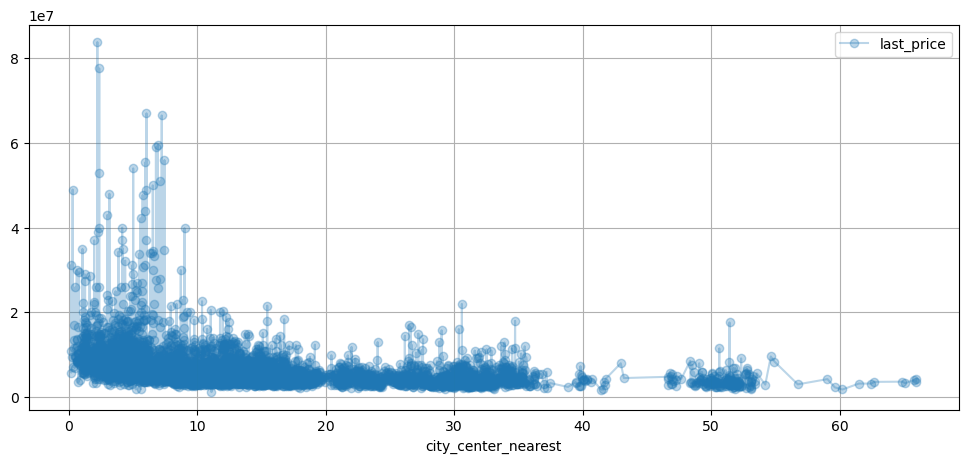

In [125]:
data.query('city_center_nearest != 100').pivot_table(index='city_center_nearest', values='last_price', aggfunc='mean').\
plot(grid=True, style ='o-', figsize=(12, 5), alpha=0.3)

In [126]:
#data.query('locality_name=="Санкт-Петербург"').pivot_table(index='city_center_nearest', values='last_price', aggfunc='mean').\
#plot(grid=True, style ='o-', figsize=(12, 5), alpha=0.3)

По графику наблюдаем наибольший разброс цен в радиусе от 0 до 10 км от центра города, там находится достаточно большое количество эксклюзивных значений дорогой недвижимости, что характерно для центра города.

In [127]:
data['last_price'].corr(data['city_center_nearest']) # вычислим коэфф.корреляции Пирсона

-0.3809579786076546

** Вывод:коэффициент корреляции Пирсона отрицательный, то есть, цена тем больше, чем меньше расстояние до центра. Однако. модуль равен 0.4, следовательно зависимость не очень сильная. По графику мы можем наглядно увидеть, что в радиусе 10 км от центра находится недвижимость с самой дорогой стоимостью квадратного метра.**

<div class="alert alert-success">


После 7-8 км заметно, что цена меняется. Это возможный центр города: самый дорогой по стоимости жилья район в Санкт-Петербурге риелторы назвали "Золотой треугольник". Дома "Золотого треугольника" находятся в пределах Невского проспекта, набережной реки Фонтанки и Дворцовой набережной.
Для географической справки: https://zen.yandex.ru/media/id/5cb4ebcc0a51a300b5b1f60d/zolotoi-treugolnik-sanktpeterburga-chto-eto-i-gde-nahoditsia-5edf942db1204610073e88b2 

</div>

## Общий вывод

In [128]:
# выводы выделены по тексту курсивом

**Целью данного исследования было:**

**1. Изучить следующие параметры объектов:**

**- общая площадь;**

*На гистограмме два отчетливых пика: первый соответствует площадям примерно 30-40 кв.м, второй примерно 50-60 кв.м, как правило, это 1-2 комнатные квартиры. Из этого можно сделать вывод, что недвижимости с данными площадями больше на рынке.*

**- жилая площадь;**

*На гистограмме наблюдаем три пика. Первый соответсвует жилой площади 18 кв.м (однокомнатные квартиры и студии), второй 30 кв.м (двухкомнатные квартиры), третий 45 кв.м (трехкомнатные или большие двухкомнатные квартиры). Из гистограммы можем заключить, что одно- и двух-комнатных квартир в датасете больше всего.*

**- площадь кухни;**

*Наблюдаем пики на 6 кв.м, 7-9 кв.м и 10-11 кв.м что соответствует стандартным площадям кухни в многоквартирных домах старой планировки (хрущевки), улучшенной и новой.*

**- цена объекта;**

*В датасете больше всего недвижимости стоимостью от 3 до 5 млн.руб.*

**- количество комнат;**

*В датасете больше всего представлено недвижимости с 1 - 2 комнатами, чуть меньше с 3. 4-5-6 комнатных квартир меньше всего на рынке.*

**- высота потолков;**

*Cамая распространенная высота потолка 2.5 - 2.65 м*

**- этаж квартиры;**

*Самый большой процент недвижимости продается на 1 этаже, далее можно выделить пик с 1 по 5 этаж - пятиэтажные дома и с 1 по 9 - девятиэтажные дома. То есть больше всего в датасете представлено недвижимости в пятиэтажках, далее следуют девятиэтажки. Более высотных домов значительно меньше.*

**- тип этажа квартиры («первый», «последний», «другой»);**

*Больше всего недвижимости представлено на промежуточных этажах, на крайних(первых и последнем) меньше и примерно одинаковое количество.*

**- общее количество этажей в доме;**

*Больше всего в датасете представлено пятиэтажек, девятиэтажек и шестнадцатиэтажек.*

**- расстояние до центра города в метрах;**

*Больше всего недвижимости в датасете находится на расстоянии 5-20 км от центра города, где в свою очередь можно выделить характерный пик в 10-17 км.*

**- расстояние до ближайшего аэропорта;**

*Больше всего недвижимости в датасете находится на расстоянии от 10 до 40 км от аэропорта.*

**- расстояние до ближайшего парка;**

*Чаще всего парки находятся в радиусе 1 км, самое распространенное расстояние до парка - 500м.*

**- день и месяц публикации объявления.**

*Чаще всего объявления публиковались на буднях - с пн по пт, что касается месяца, то видим, что есть всплеск публикаций в феврале-апреле, затем небольшой спад в мае и плавный подъем с июня по ноябрь. В декабре и январе публикаций было мало, как в мае.*

**2. Изучить, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление.** 

*Вывод: обычно продажа занимает около 100 дней (Q2= 99), то есть примерно 3 месяца. Быстрыми можно считать продажи которые лежат левее от медианы, то есть меньше 100 дней, а необычно долгими, которые на графике boxplot лежат за пределами Q3+1.5*IQR, то есть более 500 дней.*
 
**3. Изучить, какие факторы больше всего влияют на общую (полную) стоимость объекта.**

**Найти или опровергнуть зависимость цены:**

**- общей площади;**

наблюдаем прямопропорциональную зависимость: стоимость недвижимости увеличивается с увеличением общей площади. Коэффициент корреляции равен 0.72, что говорит о достаточно сильной связи.

**- жилой площади;**

*Стоимость недвижимости увеличивается с увеличением жилой площади. Коэффициент корреляции равен 0,64, что говорит о наличии связи, однако не слишком сильной.*

**- площади кухни;**

*Стоимость недвижимости увеличивается с увеличением площади кухни. Коэффициент корреляции равен 0,47, что говорит о наличии связи, однако не слишком сильной.*

**- количества комнат;**

*Стоимость недвижимости увеличивается с увеличением числа комнат. Коэфф.корреляции Пирсона равен 0,44, что говорит о наличии связи, однако не слишком сильной.*

**- этажа, на котором расположена квартира (первый, последний, другой);**

*Самая дорогая недвижимость находится на промежуточных этажах, самая дешевая недвижимость - на 1ом, на последних 
этажах стоимость в 2 больше, чем на первых и в 2 меньше, чем на промежуточных.*

**- даты размещения (день недели, месяц, год)**

*Наблюдаем уменьшение стоимости недвижимости в зависимости от начала недели к концу. Самая дорогая недвижимость была выложена в будние дни (пик во вторник), самая дешевая - в пятницу и выходные дни.*

*Самая дорогая недвижимость была размещена в продаже в апреле и декабре, самая дешевая летом - в мае, июне и июле.Коэфф.Пирсона не применяется.*

*Наблюдаем спад стоимости недвижимости с 2014 до 2016 года. Однако, здесь стоит отметить, что в 2014 и 2015 размещено менее 1% объявлений от датафрейма. В 2019 году по сравнению с плато 2016-2018 г наблюдаем росто стоимости недвижимости. Коэфф.Пирсона не применяется.*

**4. Расчет средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. 
Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра.** 

*Самая дорогая недвижимость в Санкт-Петербурге (110 000 руб./кв.м), что предсказуемо. Далее по убыванию следуют пригороды СПб, в Выборге стоимость квадратного метра (58 000 руб./кв.м) практически в 2 раза дешевле, чем в СПб..*


**5. Изучить цену каждого километра**

*По графику наблюдаем наибольший разброс цен в радиусе от 0 до 10 км от центра города, там находится достаточно большое количество эксклюзивных значений дорогой недвижимости, что характерно для центра города.*

*Коэффициент корреляции Пирсона отрицательный, то есть, цена тем больше, чем меньше расстояние до центра. Однако. модуль равен 0.4, следовательно зависимость не очень сильная. По графику мы можем наглядно увидеть, что в радиусе 10 км от центра находится недвижимость с самой дорогой стоимостью квадратного метра.*